In [1]:
import snappy
import time
import matplotlib.pyplot as plt
import FHDpy.SLP as SLP
import numpy as np
import copy

# Twister + Snappy

In [2]:
# Create T2
S = snappy.twister.Surface('S_1')
S.info(True)
print('Euler characteristic: ', S.Euler_characteristic)
print('Number of squares: ', S.num_squares)
print('Number of vertices: ', S.num_vertices)

A Twister surface of genus 1 with 0 boundary component(s)
Loops: a, b
Inverse names: A, B
Arcs: 
Inverse names: 
Macros: 
Intersection matrix:
['', 'a', 'b']
['a', 0, 1]
['b', 1, 0]
Euler characteristic:  0
Number of squares:  1
Number of vertices:  1


In [3]:
# Make manifold with Heegaard splitting
M = S.splitting(gluing= 'bAbAbAbA', handles= 'a*A')
print('Fundamental group:', M.fundamental_group())
print('Homology: ', M.homology())
print('Number of tetrahedra: ', M.num_tetrahedra())

Fundamental group: Generators:
   a
Relators:
   aaaaaaaaaaaaaaaaaaaaa
Homology:  Z/21
Number of tetrahedra:  2


In [4]:
M.homology()

Z/21

# FHD implementation

In [5]:
class FHD_genus1(SLP.SLP):
    def __init__(self):
        list_form = ['b*', 'c*', '#0.#1']
        gen = {'a': SLP.SLP(['b','c','a','#0.#1', '#3.#2']), 'b': SLP.SLP(['c*', 'a*','b','#0.#1','#3.#2']), 'A': SLP.SLP(['c*','b*','a','#0.#1', '#3.#2']), 'B': SLP.SLP(['a', 'c','b','#0.#1','#3.#2'])}
        
        SLP.SLP.__init__(self, list_form)
        self.gen = gen
            
    def dehn_twist(self, generator):
        for edge in generator:
            # If not a inverse twist, simply substitute each occurence of the edge by the new subsequence. If, however, an inverse twist, we replace its lowered version (i.e., the edge label itself) by
            # the subsequence.
            self.substitute(edge, self.gen[edge], inplace = True) if edge.islower() else self.substitute(edge.lower(), self.gen[edge], inplace = True)
        return None
    
    def homology(self):
        return snappy.AbelianGroup([[self.signed_count('a')-self.signed_count('a*')]])

In [6]:
'A'.lower()

'a'

In [7]:
class FHDLong:
    '''
    Computes an intersection sequence presentation for the Heegaard diagram of a 3-manifold represented by a Heegaard word (i.e., an element of the mapping class group of the splitting surface). 
    
    Parameters
    ----------
    alpha_curves_standard : dict
    Dictionary with each key being an alpha curve and its associated value being an SLP of the intersection sequence of a twin of the curve.
    
    alpha_curves_edge : dict
    Dictionary with each key being an alpha curve and its associated value being the edge list of the curve.

    generators_standard : dict
    Dictionary with each key being a generator curve and its associated value being the intersection sequence of a twin of the curve. We use lower letters to represent the left twins and upper letters for the right
    twins. In practice, we do not use right twins, but they might be useful when considering alternative cell structures for the surface.
    
    generators_edge : dict
    Dictionary with each key being a generator curve and its associated value being an edge list representation.
    '''
    
    def __init__(self, alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge):
      
        # Deep copy is important because we will be updating these things and, if not deep copied, the assignments will be only pointers pointing to the same object, which will be updated
        alpha_curves_standard = copy.deepcopy(alpha_curves_standard)
        self.alpha = copy.deepcopy(alpha_curves_edges.copy())
        generators_standard = copy.deepcopy(generators_standard.copy())
        generators_edge = copy.deepcopy(generators_edge.copy())
        
        
        # Make generators from twins
        generators = {}
        for curve in generators_standard.keys():
            if curve.islower(): # If we use the left twin
                # Add the edge as the last position to the SLP of the twin
                generators[curve] = SLP.SLP(generators_standard[curve].list_form + [curve, '#' + str(len(generators_standard[curve].list_form)-1) + '.#' + str(len(generators_standard[curve].list_form))])
                inverse_slp = generators_standard[curve].inverse()
                generators[curve.upper()] = SLP.SLP(inverse_slp.list_form + [curve, '#' + str(len(inverse_slp.list_form)-1) + '.#' + str(len(inverse_slp.list_form))])
            else: # If we take the right twin
                # Add the edge as the first position to the SLP of the twin
                generators[curve.lower()] = SLP.SLP(generators_standard[curve].list_form + [curve.lower(), '#' + str(len(generators_standard[curve].list_form)) + '.#' + str(len(generators_standard[curve].list_form)-1)])
                inverse_slp = generators_standard[curve].inverse()
                generators[curve] = SLP.SLP(inverse_slp.list_form + [curve.lower(), '#' + str(len(inverse_slp.list_form)) + '.#' + str(len(inverse_slp.list_form)-1)])
        self.generators = generators


        self.generators_edge = generators_edge        
        # Add the inverse of the generators to the generator list
        # Need to make a new dictionar because we cannot change the length of a dictionary while updating
        inverse_edges = {}
        for curve in self.generators_edge.keys():
            # Simply add everything with upper letters
            inverse_edges[curve.upper()] = [edge.upper() for edge in self.generators_edge[curve]]
        # Add the new generators to list
        self.generators_edge.update(inverse_edges)
    
        
        # As usual, the alpha curves will be edged
        self.twins = list(alpha_curves_standard.values())
        
         # Initial diagram is the trivial diagram of S2 x S1
        self.beta = copy.deepcopy(self.twins)
        
    
    def reset(self):
        '''
        Resests the Heegaard diagram, that is, make the beta curves parallel to the alpha curves.
  
        '''
        self.beta = copy.deepcopy(self.twins)
        return None

    def dehn_twist(self, word):
        '''
        Updates the Heegaard diagram by applying the word, in the mapping class group of the surface, to each beta curve.
        
        Parameters
        ----------
        word : str
        Word in the mapping class group of the surface, where each letter is a generator curve in. Lower letters indicate right Dehn twists and upper letters indicate left. No marker of multiplication
        is required. Word is read from left to right (i.e., reading direction).
        
        Ex.: 'aBc' represents a right Dehn twist about a, followed by a left Dehn twist about b and a right Dehn twist about c.
        '''
        
        # For each generator in the Heegaard word read left to right (i.e., inverse of function application)
        for curve in word:
            # We use Twister convention of right Dehn twists positive and left negative
            sign = curve.islower()
            #Get all edges that are in the curve
            edges = self.generators_edge[curve]
            for edge in edges:
                # Update each beta curve by applying the mapping class
                for beta in self.beta:
                    # If not a inverse twist, simply substitute each occurence of the edge by the new subsequence. If, however, an inverse twist, we replace its lowered version (i.e., the edge label itself) by
                    # the subsequence
                    beta.substitute(edge, self.generators[edge], inplace = True) if sign else beta.substitute(edge.lower(), self.generators[edge], inplace = True)
        return None
    
    def homology(self, matrix = False):
        '''
        Computes the first homology group of the manifold represented by the Heegaard diagram.
        
        Parameters
        ----------
        matrix : bool
        If True, returns a presentation of the group. 
        '''
        presentation_matrix = []
        
        # Iterate over each beta curve
        for beta in self.beta:  
            beta_relator = []
            
            # Iterate over each alpha curve
            for alpha in self.alpha.keys():
                # For each alpha curve, adds the number of positive minus the number of negative intersections with each edge
                 beta_relator.append(sum([beta.signed_count(edge)-beta.signed_count(edge + '*') for edge in self.alpha[alpha]]))
            
                
            # Append the relator to the presentation matrix as a new row
            presentation_matrix.append(beta_relator)
        
        if matrix: # If matix ==  True, returns the presrntation matrix
            return presentation_matrix, snappy.AbelianGroup(presentation_matrix)
        else:
            return snappy.AbelianGroup(presentation_matrix)

In [8]:
s = FHD_genus1()
gluing = 'abA'
s.dehn_twist(gluing)
s.get_uncompressed().list_form[-1]

'b*.c*.b*.a.c.c*'

In [9]:
M = S.splitting(gluing= gluing, handles= 'a*A')
M.fundamental_group()

Generators:
   
Relators:
   

In [10]:
s = FHD_genus1()
gluing = 'bAaaB'
s.dehn_twist(gluing)
M = S.splitting(gluing= gluing, handles= 'a*A')

assert s.homology() == M.homology()

In [11]:
alpha_curves_standard = {'a': SLP.SLP(['b*'])}
alpha_curves_edges = {'a':['a']}
generators_standard = {'a': SLP.SLP(['b']), 'b': SLP.SLP(['a*'])}
generators_edge = {'a':['a'], 'b':['b']}

s = FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
gluing = 'bAaaB'
s.dehn_twist(gluing)

M = S.splitting(gluing= gluing, handles= 'a*A')
assert s.homology() == M.homology()

In [12]:
alpha_curves_standard = {'a': SLP.SLP(['b*'])}
alpha_curves_edges = {'a':['a']}
generators_standard = {'A': SLP.SLP(['b']), 'B': SLP.SLP(['a*'])}
generators_edge = {'a':['a'], 'b':['b']}

s = FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
gluing = 'bAaaB'
s.dehn_twist(gluing)

M = S.splitting(gluing= gluing, handles= 'a*A')
assert s.homology() == M.homology()

In [13]:
s.generators['A'].get_uncompressed().list_form[-1]

'a.b*'

# Genus 1

In [14]:
def fib(n):
    fib_list = [0,1]
    while len(fib_list) < n:
        fib_list.append(fib_list[-1] + fib_list[-2])
    
    return fib_list

In [15]:
hom = fib(1001)[0::2]

In [16]:
def modular_representation(word):
    '''
    Uses the usual representation of the mapping class group of the torus in Z^2 to compute the homology of the Lens' space given by a Heegaard word.
    See Benson Farb and Dan Margalit. A primer on mapping class groups. Vol. 49. Princeton university press, 2011 for details.
    
    Parameters
    ----------
    word : str
    Word in the mapping class group of the surface, where each letter is a generator curve in. Lower letters indicate right Dehn twists and upper letters indicate left. No marker of multiplication
    is required. Word is read from left to right (i.e., reading direction).

    Ex.: 'aBc' represents a right Dehn twist about a, followed by a left Dehn twist about b and a right Dehn twist about c.
    '''
    
    generators = {'A' : np.array([[1,1],[0,1]]), 'B' : np.array([[1,0],[-1,1]]),  'a' : np.array([[1,-1],[0,1]]), 'b' : np.array([[1,0],[1,1]])}
    
    vec = np.array([[1],[0]])
    vec.astype(np.int64)
    
    for curve in word:
        vec = generators[curve] @ vec
        
    return  snappy.AbelianGroup([[int(vec[1][0])]])

def modular_representation_exponential(n):
    '''
    Uses the usual representation of the mapping class group of the torus in Z^2 to compute the homology of the Lens' space given by a Heegaard word of form 'bA'*n.
    See Benson Farb and Dan Margalit. A primer on mapping class groups. Vol. 49. Princeton university press, 2011 for details.
    
    Parameters
    ----------
    n : str
    Half the length of the word.
    '''
    
    A = np.array([[1,1],[0,1]])
    B = np.array([[1,0],[-1,1]])
    b = np.linalg.inv(B)
    vec = np.array([[1],[0]])
    
    for i in range(n):
        vec = A @ b @ vec
    return snappy.AbelianGroup([[int(vec[1][0])]])

In [17]:
snappy.AbelianGroup([[30]]).order()

30

In [18]:
modular_representation('bA'*35).order()

190392490709135

In [19]:
for n in [1,2,23,24,25,100, 500]:
    s = FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
    gluing = 'bA'*n
    s.dehn_twist(gluing)
    M = S.splitting(gluing = gluing, handles= 'a*A')
    M2 = S.splitting(gluing = gluing, handles= 'a*A', optimize = False)


    print('\nn = ' + str(n) + ':\n' + 'Fibonacci: ', snappy.AbelianGroup([[hom[n]]])) 
    print('Modular representation (word): ', modular_representation(gluing))
    print('Modular representation (n): ', modular_representation_exponential(n))
    print('Our homology: ', s.homology())
    print('Twister homology: ', M.homology())
    print('Twister homology (optimization off): ', M2.homology())



n = 1:
Fibonacci:  0
Modular representation (word):  0
Modular representation (n):  0
Our homology:  0
Twister homology:  0
Twister homology (optimization off):  0

n = 2:
Fibonacci:  Z/3
Modular representation (word):  Z/3
Modular representation (n):  Z/3
Our homology:  Z/3
Twister homology:  Z/3
Twister homology (optimization off):  Z/3

n = 23:
Fibonacci:  Z/1836311903
Modular representation (word):  Z/1836311903
Modular representation (n):  Z/1836311903
Our homology:  Z/1836311903
Twister homology:  Z/1836311903
Twister homology (optimization off):  Z/1836311903

n = 24:
Fibonacci:  Z/4807526976
Modular representation (word):  Z/4807526976
Modular representation (n):  Z/4807526976
Our homology:  Z/4807526976
Twister homology:  Z/4807526976
Twister homology (optimization off):  Z/4807526976

n = 25:
Fibonacci:  Z/12586269025
Modular representation (word):  Z/12586269025
Modular representation (n):  Z/12586269025
Our homology:  Z/12586269025
Twister homology:  Z/6699635210
Twister h

In [24]:
n_max = 35

len(list(range(0,2*n_max,2)))

35

In [27]:
2*np.array(range(1,n_max))

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68])

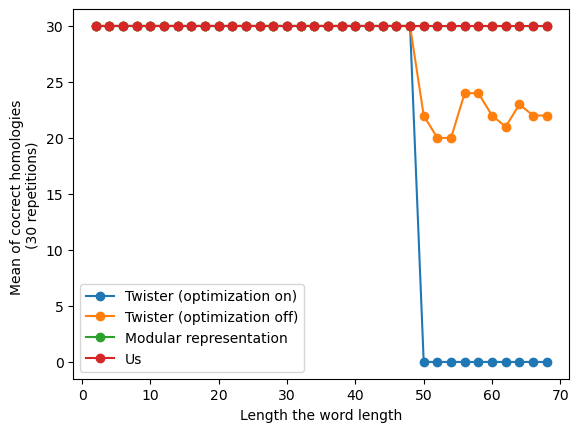

In [29]:
n_rep = 30
n_max = 35

us = []
twister = []
twister_no_optimization = []
reps = []

for n in range(1,n_max):
    gluing = 'bA'*n
    real_homology = snappy.AbelianGroup([[hom[n]]])
    
    counter_us = 0
    counter_twister = 0
    counter_twister_no_optimization = 0
    counter_rep = 0
    
    for rep in range(n_rep):
        s = FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
        s.dehn_twist(gluing)
        if s.homology() == real_homology: counter_us += 1
        
        M = S.splitting(gluing = gluing, handles= 'a*A')
        if M.homology() == real_homology: counter_twister += 1
        
        M = S.splitting(gluing = gluing, handles= 'a*A', optimize = False)
        if M.homology() == real_homology: counter_twister_no_optimization += 1
        
        if modular_representation(gluing) == real_homology: counter_rep += 1
        
        
        
    us.append(np.sum(counter_us))
    twister.append(np.sum(counter_twister))
    twister_no_optimization.append(np.sum(counter_twister_no_optimization))
    reps.append(np.sum(counter_rep))
    
        
plt.plot(2*np.array(range(1,n_max)), twister, '-o', label = 'Twister (optimization on)')
plt.plot(2*np.array(range(1,n_max)), twister_no_optimization, '-o', label = 'Twister (optimization off)')
plt.plot(2*np.array(range(1,n_max)), reps, '-o', label = 'Modular representation')
plt.plot(2*np.array(range(1,n_max)), us, '-o', label = 'Us')

plt.xlabel('Length the word length')
plt.ylabel('Number of cocrect homologies \n(' + str(n_rep) + ' repetitions)')

plt.legend()
plt.show()

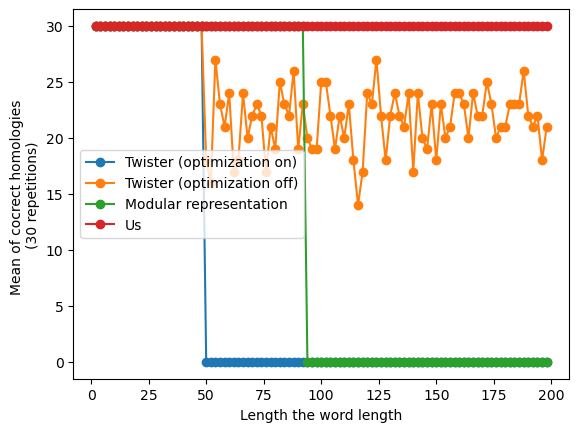

In [30]:
n_rep = 30
n_max = 100

us = []
twister = []
twister_no_optimization = []
reps = []

for n in range(1,n_max):
    gluing = 'bA'*n
    real_homology = snappy.AbelianGroup([[hom[n]]])
    
    counter_us = 0
    counter_twister = 0
    counter_twister_no_optimization = 0
    counter_rep = 0
    
    for rep in range(n_rep):
        s = FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
        s.dehn_twist(gluing)
        if s.homology() == real_homology: counter_us += 1
        
        M = S.splitting(gluing = gluing, handles= 'a*A')
        if M.homology() == real_homology: counter_twister += 1
        
        M = S.splitting(gluing = gluing, handles= 'a*A', optimize = False)
        if M.homology() == real_homology: counter_twister_no_optimization += 1
        
        if modular_representation(gluing) == real_homology: counter_rep += 1
        
        
        
    us.append(np.sum(counter_us))
    twister.append(np.sum(counter_twister))
    twister_no_optimization.append(np.sum(counter_twister_no_optimization))
    reps.append(np.sum(counter_rep))
    
        
plt.plot(2*np.array(range(1,n_max)), twister, '-o', label = 'Twister (optimization on)')
plt.plot(2*np.array(range(1,n_max)), twister_no_optimization, '-o', label = 'Twister (optimization off)')
plt.plot(2*np.array(range(1,n_max)), reps, '-o', label = 'Modular representation')
plt.plot(2*np.array(range(1,n_max)), us, '-o', label = 'Us')

plt.xlabel('Length the word length')
plt.ylabel('Number of cocrect homologies \n(' + str(n_rep) + ' repetitions)')

plt.legend()
plt.show()

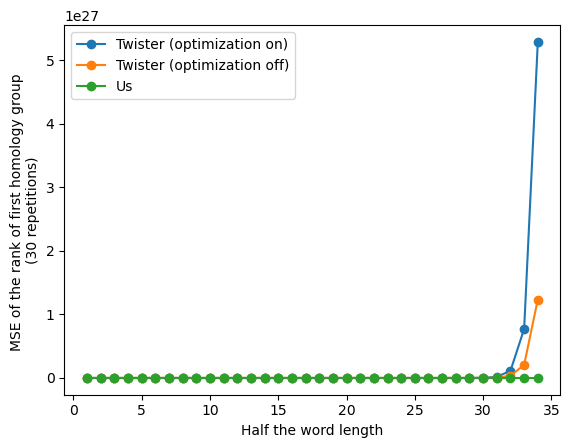

In [51]:
n_rep = 30
n_max = 35

us_mean = []
twister_mean = []
twister_no_optimization_mean = []

us_std = []
twister_std = []
twister_no_optimization_std = []

for n in range(1,n_max):
    gluing = 'bA'*n
    real_homology = snappy.AbelianGroup([[hom[n]]]).order()
    
    order_us = []
    order_twister = []
    order_twister_no_optimization = []

    for rep in range(n_rep):
        s = FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
        s.dehn_twist(gluing)
        order_us.append((s.homology().order() - real_homology)**2)
        
        M = S.splitting(gluing = gluing, handles= 'a*A')
        order_twister.append((M.homology().order() - real_homology)**2)
        
        M = S.splitting(gluing = gluing, handles= 'a*A', optimize = False)
        order_twister_no_optimization.append((M.homology().order() - real_homology)**2)
        
    us_mean.append(np.mean(order_us))
    twister_mean.append(np.mean(order_twister))
    twister_no_optimization_mean.append(np.mean(order_twister_no_optimization))
    
    us_std.append(np.std(order_us))
    twister_std.append(np.std(order_twister))
    twister_no_optimization_std.append(np.std(order_twister_no_optimization))
    
        
plt.plot(range(1,n_max), twister_mean, '-o', label = 'Twister (optimization on)')
plt.plot(range(1,n_max), twister_no_optimization_mean, '-o', label = 'Twister (optimization off)')
plt.plot(range(1,n_max), us_mean, '-o', label = 'Us')

plt.xlabel('Half the word length')
plt.ylabel('MSE of the rank of first homology group \n(' + str(n_rep) + ' repetitions)')

plt.legend()
plt.show()

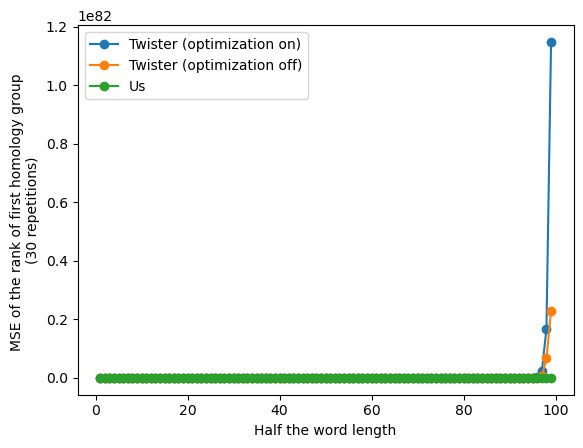

In [52]:
n_rep = 30
n_max = 100

us_mean = []
twister_mean = []
twister_no_optimization_mean = []

us_std = []
twister_std = []
twister_no_optimization_std = []

for n in range(1,n_max):
    gluing = 'bA'*n
    real_homology = snappy.AbelianGroup([[hom[n]]]).order()
    
    order_us = []
    order_twister = []
    order_twister_no_optimization = []

    for rep in range(n_rep):
        s = FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
        s.dehn_twist(gluing)
        order_us.append((s.homology().order() - real_homology)**2)
        
        M = S.splitting(gluing = gluing, handles= 'a*A')
        order_twister.append((M.homology().order() - real_homology)**2)
        
        M = S.splitting(gluing = gluing, handles= 'a*A', optimize = False)
        order_twister_no_optimization.append((M.homology().order() - real_homology)**2)
        
    us_mean.append(np.mean(order_us))
    twister_mean.append(np.mean(order_twister))
    twister_no_optimization_mean.append(np.mean(order_twister_no_optimization))
    
    us_std.append(np.std(order_us))
    twister_std.append(np.std(order_twister))
    twister_no_optimization_std.append(np.std(order_twister_no_optimization))
    
        
plt.plot(range(1,n_max), twister_mean, '-o', label = 'Twister (optimization on)')
plt.plot(range(1,n_max), twister_no_optimization_mean, '-o', label = 'Twister (optimization off)')
plt.plot(range(1,n_max), us_mean, '-o', label = 'Us')

plt.xlabel('Half the word length')
plt.ylabel('MSE of the rank of first homology group \n(' + str(n_rep) + ' repetitions)')

plt.legend()
plt.show()

## Exponential

### Twister

In [164]:
S = snappy.twister.Surface('S_1')

In [165]:
gluing = 'bA'*500
    
M = S.splitting(gluing= gluing, handles= 'a*A')

M.homology()

Z/7033823157

#### Optimize

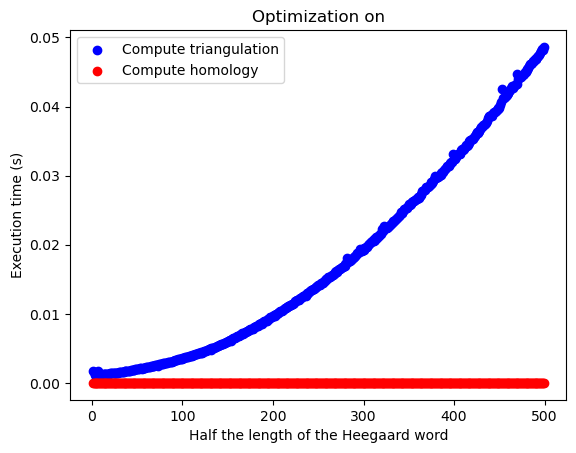

In [170]:
time_splitting = []
time_homology = []
tetra = []
n_max = 500
for n in range(1,n_max):
    gluing = 'a'*n
    
    start = time.time()
    M = S.splitting(gluing= gluing, handles= 'a*A')
    end = time.time()
    time_splitting.append(end-start)
    
    tetra.append(M.num_tetrahedra())

    start = time.time()
    M.homology()
    end = time.time()
    time_homology.append(end-start)
    
plt.scatter(range(1,n_max), time_splitting, c = 'b', label = 'Compute triangulation')
plt.scatter(range(1,n_max), time_homology, c = 'r', label = 'Compute homology')
plt.legend()
plt.xlabel('Half the length of the Heegaard word')
plt.ylabel('Execution time (s)')
plt.title('Optimization on')
plt.show()

In [171]:
np.mean([time_splitting[2*n]/time_splitting[n] for n in range(249)])

2.6540915020958544

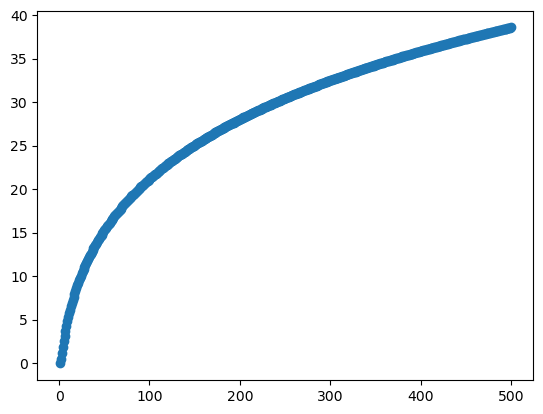

In [172]:
x = np.linspace(1,500,500)
y = np.log(x)**2
plt.scatter(x,y)

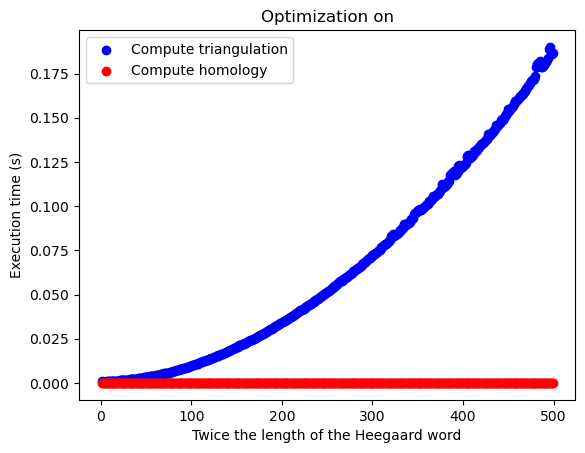

In [11]:
time_splitting = []
time_homology = []
tetra = []
n_max = 500
for n in range(1,n_max):
    gluing = 'bA'*n
    
    start = time.time()
    M = S.splitting(gluing= gluing, handles= 'a*A')
    end = time.time()
    time_splitting.append(end-start)
    
    tetra.append(M.num_tetrahedra())

    start = time.time()
    M.homology()
    end = time.time()
    time_homology.append(end-start)
    
plt.scatter(range(1,n_max), time_splitting, c = 'b', label = 'Compute triangulation')
plt.scatter(range(1,n_max), time_homology, c = 'r', label = 'Compute homology')
plt.legend()
plt.xlabel('Half the length of the Heegaard word')
plt.ylabel('Execution time (s)')
plt.title('Optimization on')
plt.show()

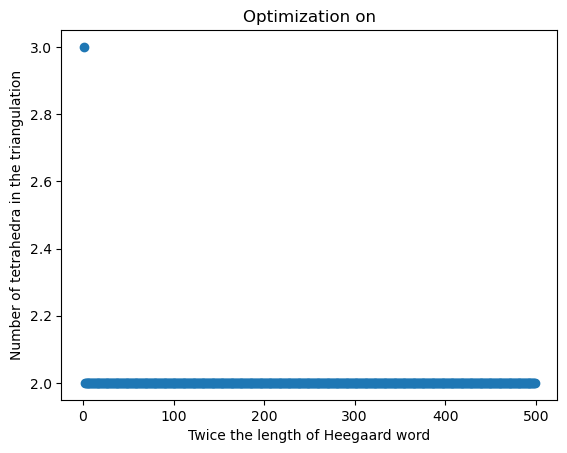

In [12]:
plt.scatter(range(1, n_max), tetra)
plt.xlabel('Half the length of Heegaard word')
plt.ylabel('Number of tetrahedra in the triangulation')
plt.title('Optimization on')
plt.show()

#### No optimize

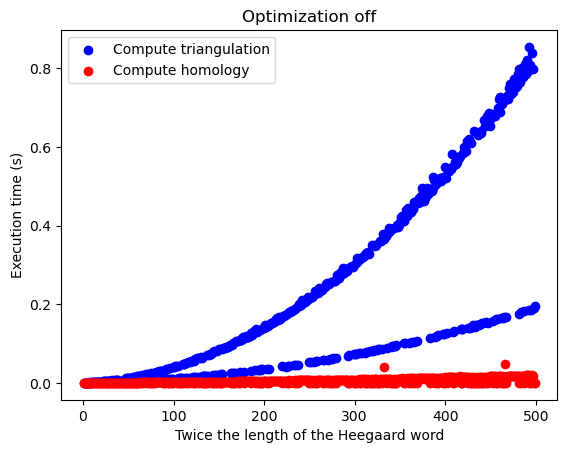

In [13]:
time_splitting_no_optimization = []
time_homology_no_optimization = []
n_max = 500
tetra_no_optimization = []
for n in range(1,n_max):
    gluing = 'bA'*n
    
    start = time.time()
    M = S.splitting(gluing= gluing, handles= 'a*A', optimize = False)
    end = time.time()
    time_splitting_no_optimization.append(end-start)
    
    tetra_no_optimization.append(M.num_tetrahedra())

    start = time.time()
    M.homology()
    end = time.time()
    time_homology_no_optimization.append(end-start)
    
plt.scatter(range(1,n_max), time_splitting_no_optimization, c = 'b', label = 'Compute triangulation')
plt.scatter(range(1,n_max), time_homology_no_optimization, c = 'r', label = 'Compute homology')
plt.legend()
plt.xlabel('Half the length of the Heegaard word')
plt.ylabel('Execution time (s)')
plt.title('Optimization off')
plt.show()

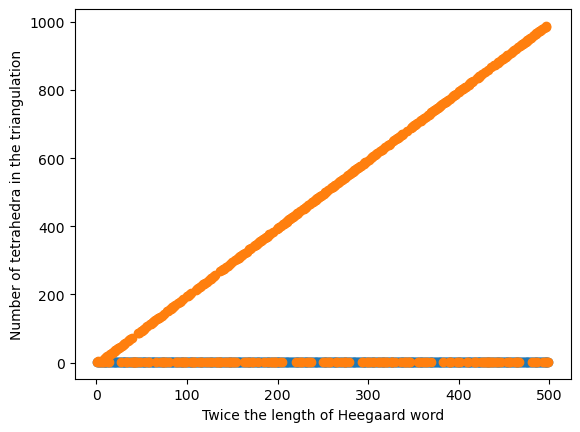

In [14]:
plt.scatter(range(1, n_max), tetra, label = 'Optimization on')
plt.scatter(range(1, n_max), tetra_no_optimization, label = 'Optimization off')

plt.xlabel('Half the length of Heegaard word')
plt.ylabel('Number of tetrahedra in the triangulation')
plt.show()

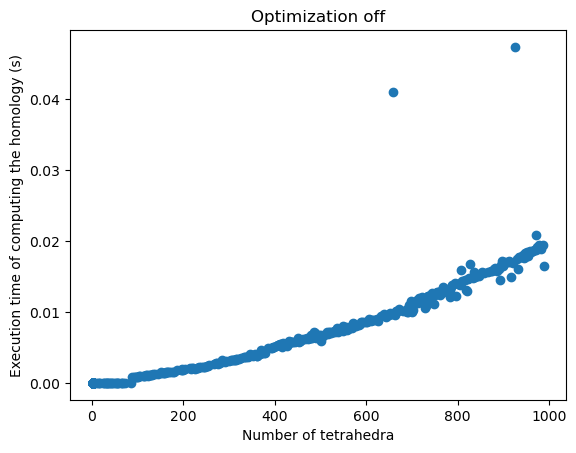

In [15]:
plt.scatter(tetra_no_optimization,time_homology_no_optimization)
plt.xlabel('Number of tetrahedra')
plt.ylabel('Execution time of computing the homology (s)')
plt.title('Optimization off')
plt.show()

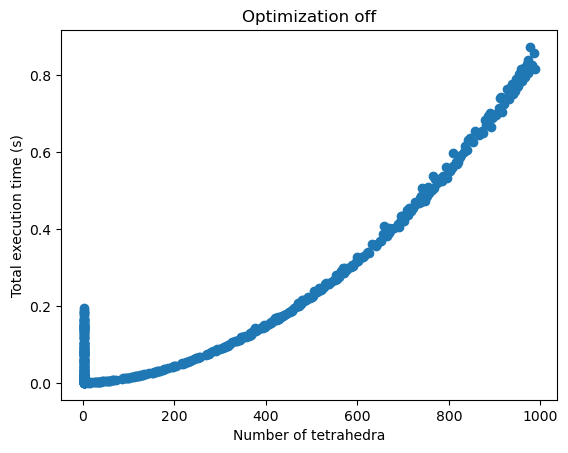

In [16]:
plt.scatter(tetra_no_optimization, np.array(time_homology_no_optimization) + np.array(time_splitting_no_optimization))
plt.xlabel('Number of tetrahedra')
plt.ylabel('Total execution time (s)')
plt.title('Optimization off')
plt.show()

### Us

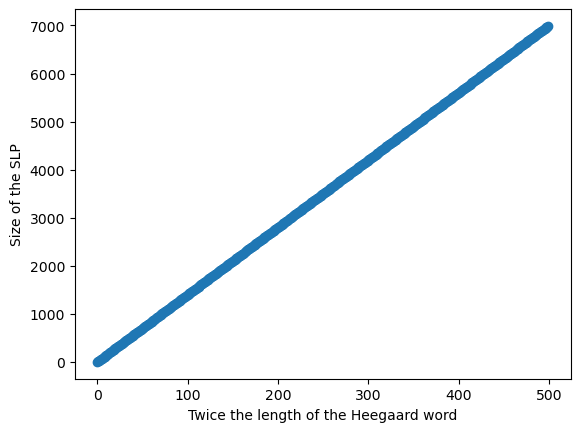

In [17]:
n = 500
sizes = []
for i in range(n):
    s = FHD_genus1()
    s.dehn_twist(i*'bA')
    sizes.append(s.complexity())
plt.scatter(range(n),sizes)
plt.xlabel('Half the length of the Heegaard word')
plt.ylabel('Size of the SLP')
plt.show()

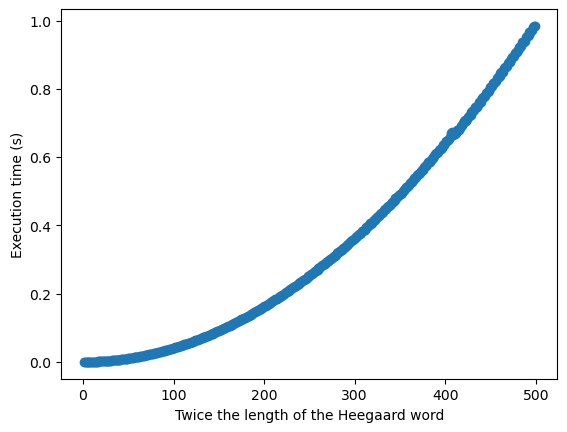

In [18]:
n_max = 500
times = []
for n in range(1,n_max):
    s = FHD_genus1()
    start = time.time()
    s.dehn_twist(n*'bA')
    s.homology()
    end = time.time()
    times.append(end-start)
plt.scatter(range(1,n_max),times)
plt.xlabel('Half the length of the Heegaard word')
plt.ylabel('Execution time (s)')
plt.show()

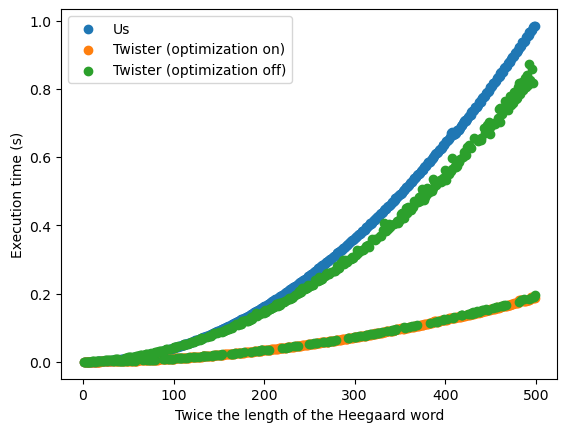

In [19]:
plt.scatter(range(1,n_max),times, label = 'Us')
plt.scatter(range(1,n_max),np.array(time_splitting) + np.array(time_homology), label = 'Twister (optimization on)')
plt.scatter(range(1,n_max), np.array(time_splitting_no_optimization) + np.array(time_homology_no_optimization), label = 'Twister (optimization off)')


plt.xlabel('Half the length of the Heegaard word')
plt.ylabel('Execution time (s)')
plt.legend()
plt.show()

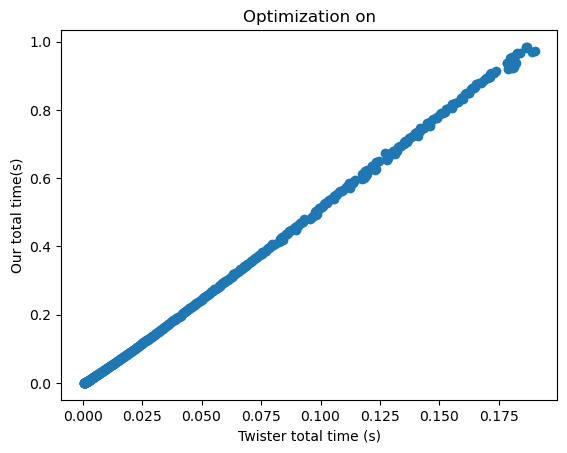

In [20]:
plt.scatter(np.array(time_splitting) + np.array(time_homology), times)
plt.xlabel('Twister total time (s)')
plt.ylabel('Our total time(s)')
plt.title('Optimization on')
plt.show()

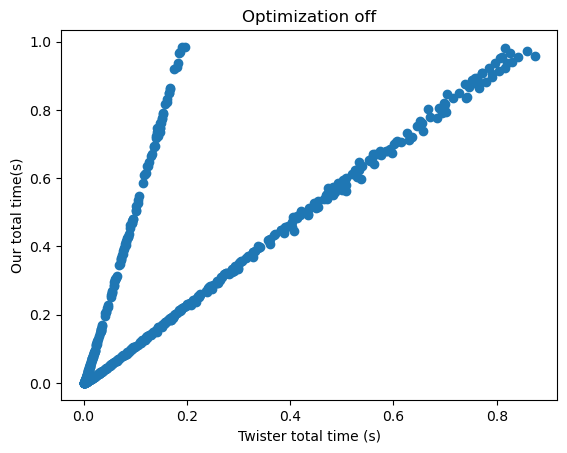

In [21]:
plt.scatter(np.array(time_splitting_no_optimization) + np.array(time_homology_no_optimization), times)
plt.xlabel('Twister total time (s)')
plt.ylabel('Our total time(s)')
plt.title('Optimization off')
plt.show()

## Random

In [22]:
n_max = 500
time_us = []
time_twister = []
time_twister_no_optimization = []

tetra = []
tetra_no_optimization = []

for n in range(1,n_max):
    word = S.random_word(n)
    
    # Us
    start = time.time()
    s = FHD_genus1()
    s.dehn_twist(word)
    s.homology()
    end = time.time()
    time_us.append(end-start)
    
    # Twister with optimization
    start = time.time()
    M = S.splitting(gluing = word, handles= 'a*A')
    M.homology()
    end = time.time()
    time_twister.append(end-start)
    tetra.append(M.num_tetrahedra())
    
    # Twister without optimization
    start = time.time()
    M = S.splitting(gluing = word, handles= 'a*A', optimize = False)
    M.homology()
    end = time.time()
    time_twister_no_optimization.append(end-start)
    tetra_no_optimization.append(M.num_tetrahedra())

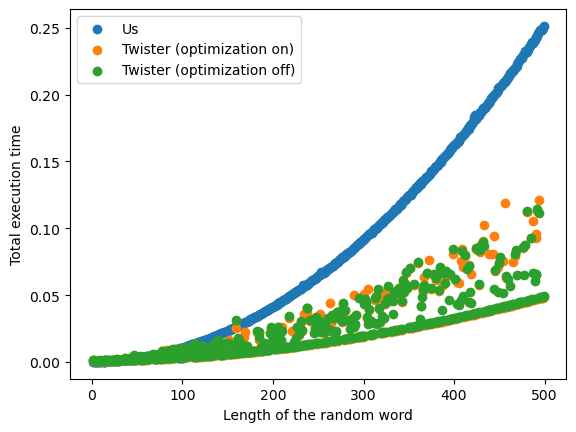

In [23]:
plt.scatter(range(1,n_max), time_us, label = 'Us')
plt.scatter(range(1,n_max), time_twister, label = 'Twister (optimization on)')
plt.scatter(range(1,n_max), time_twister_no_optimization, label = 'Twister (optimization off)')
plt.xlabel('Length of the random word')
plt.ylabel('Total execution time')
plt.legend()
plt.show()

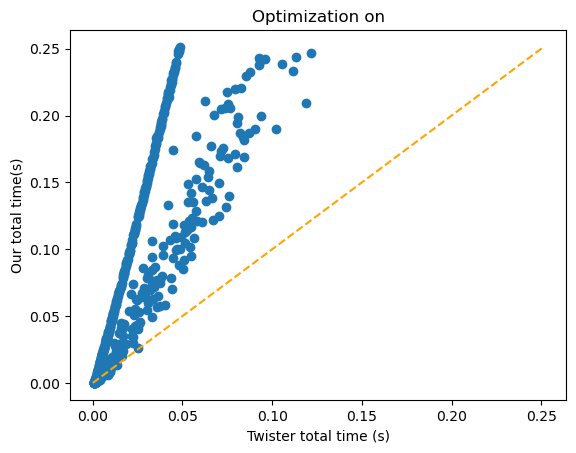

In [24]:
plt.scatter(time_twister, time_us)
plt.plot([min(time_us),max(time_us)],[min(time_us),max(time_us)], '--',c =  'orange')
plt.xlabel('Twister total time (s)')
plt.ylabel('Our total time(s)')
plt.title('Optimization on')
plt.show()

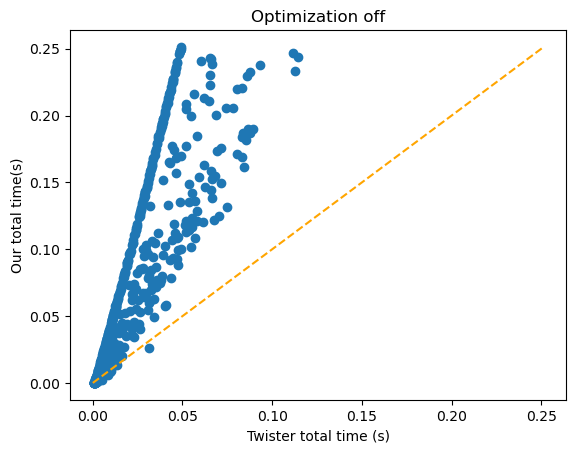

In [25]:
plt.scatter(time_twister_no_optimization, time_us)
plt.plot([min(time_us),max(time_us)],[min(time_us),max(time_us)], '--',c =  'orange')
plt.xlabel('Twister total time (s)')
plt.ylabel('Our total time(s)')
plt.title('Optimization off')
plt.show()

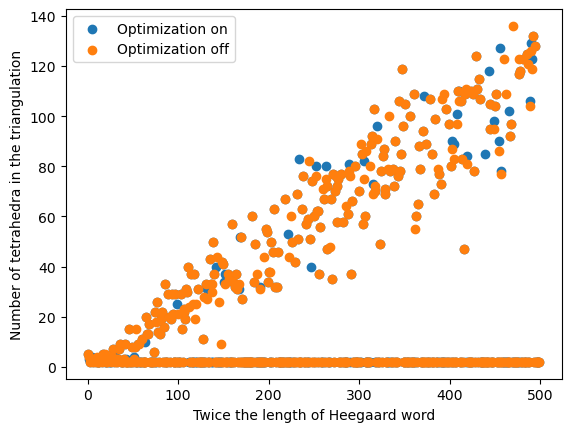

In [26]:
plt.scatter(range(1,n_max), tetra, label = 'Optimization on')
plt.scatter(range(1,n_max), tetra_no_optimization, label = 'Optimization off')

plt.xlabel('Length of Heegaard word')
plt.ylabel('Number of tetrahedra in the triangulation')
plt.legend()
plt.show()

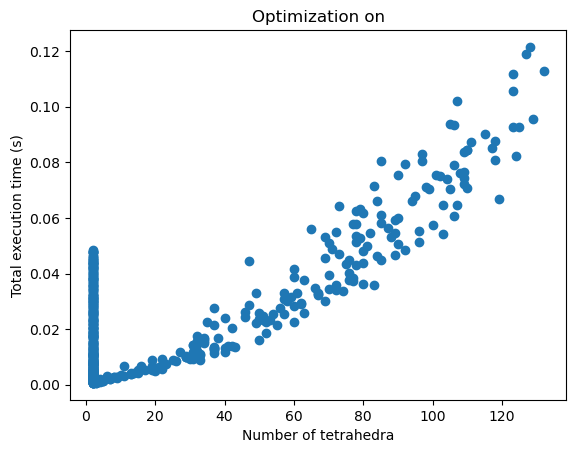

In [27]:
plt.scatter(tetra, time_twister)

plt.xlabel('Number of tetrahedra')
plt.ylabel('Total execution time (s)')
plt.title('Optimization on')
plt.show()

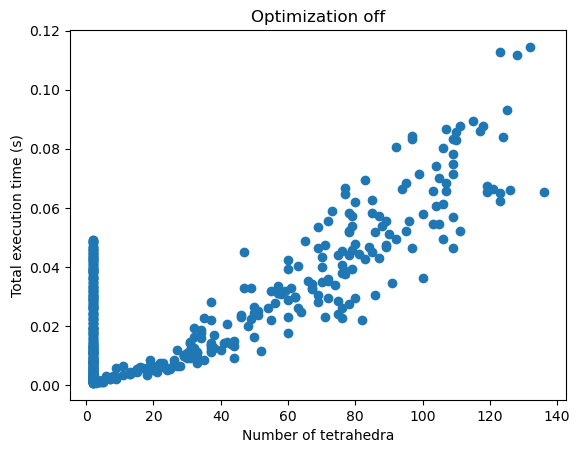

In [28]:
plt.scatter(tetra_no_optimization, time_twister_no_optimization)


plt.xlabel('Number of tetrahedra')
plt.ylabel('Total execution time (s)')
plt.title('Optimization off')
plt.show()

# Genus 2

In [151]:
# Create T2#T2
S = snappy.twister.Surface('S_2')
S.info(True)
print('Euler characteristic: ', S.Euler_characteristic)
print('Number of squares: ', S.num_squares)
print('Number of vertices: ', S.num_vertices)

A Twister surface of genus 2 with 0 boundary component(s)
Loops: a, b, c, d, e
Inverse names: A, B, C, D, E
Arcs: 
Inverse names: 
Macros: 
Intersection matrix:
['', 'a', 'b', 'c', 'd', 'e']
['a', 0, 1, 0, 0, 0]
['b', 1, 0, 1, 0, 0]
['c', 0, 1, 0, 1, 0]
['d', 0, 0, 1, 0, 1]
['e', 0, 0, 0, 1, 0]
Euler characteristic:  -2
Number of squares:  4
Number of vertices:  2


In [152]:
gluing = ''
M = S.splitting(gluing= gluing, handles= 'a*e*B*D')

    
print('Fundamental group:', M.fundamental_group())
print('Homology: ', M.homology())
print('Number of tetrahedra: ', M.num_tetrahedra())

Fundamental group: Generators:
   
Relators:
   
Homology:  0
Number of tetrahedra:  3


In [153]:
alpha_curves_standard = {'a': SLP.SLP(['b']), 'e': SLP.SLP(['d*'])}
alpha_curves_edges = {'a':['a'], 'e':['e']}
generators_standard = {'a': SLP.SLP(['b*']), 'b': SLP.SLP(['c*','a','#0.#1']), 'c': SLP.SLP(['b','d','#0.#1']),'d': SLP.SLP(['c*','e*','#0.#1']), 'e': SLP.SLP(['d'])}
generators_edge = {'a':['a'], 'b':['b'], 'c':['c'], 'd':['d'], 'e':['e']}

In [154]:
s = FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
gluing = 'EBbCdAae'*3
s.dehn_twist(gluing)
M = S.splitting(gluing= gluing, handles= 'a*e*A*E')    

assert s.homology() == M.homology()

## Exponential

In [155]:
n_max = 100
time_us = []
time_twister = []
time_twister_no_optimization = []

tetra = []
tetra_no_optimization = []

for n in range(1,n_max):
    word = 'abcde'*n
    
    # Us
    start = time.time()
    s = FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
    s.dehn_twist(word)
    s.homology()
    end = time.time()
    time_us.append(end-start)
    
    # Twister with optimization
    start = time.time()
    M = S.splitting(gluing = word, handles= 'a*e*A*E')
    M.homology()
    end = time.time()
    time_twister.append(end-start)
    tetra.append(M.num_tetrahedra())
    
    # Twister without optimization
    start = time.time()
    M = S.splitting(gluing = word, handles= 'a*e*A*E', optimize = False)
    M.homology()
    end = time.time()
    time_twister_no_optimization.append(end-start)
    tetra_no_optimization.append(M.num_tetrahedra())

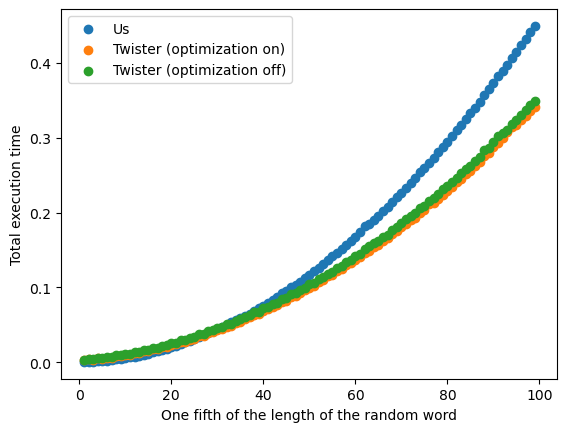

In [156]:
plt.scatter(range(1,n_max), time_us, label = 'Us')
plt.scatter(range(1,n_max), time_twister, label = 'Twister (optimization on)')
plt.scatter(range(1,n_max), time_twister_no_optimization, label = 'Twister (optimization off)')
plt.xlabel('One fifth of the length of the random word')
plt.ylabel('Total execution time')
plt.legend()
plt.show()

## Random

In [157]:
n_max = 500
time_us = []
time_twister = []
time_twister_no_optimization = []

tetra = []
tetra_no_optimization = []

for n in range(1,n_max):
    word = S.random_word(n)
    
    # Us
    start = time.time()
    s = FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
    s.dehn_twist(word)
    s.homology()
    end = time.time()
    time_us.append(end-start)
    
    # Twister with optimization
    start = time.time()
    M = S.splitting(gluing = word, handles= 'a*e*A*E')
    M.homology()
    end = time.time()
    time_twister.append(end-start)
    tetra.append(M.num_tetrahedra())
    
    # Twister without optimization
    start = time.time()
    M = S.splitting(gluing = word, handles= 'a*e*A*E', optimize = False)
    M.homology()
    end = time.time()
    time_twister_no_optimization.append(end-start)
    tetra_no_optimization.append(M.num_tetrahedra())

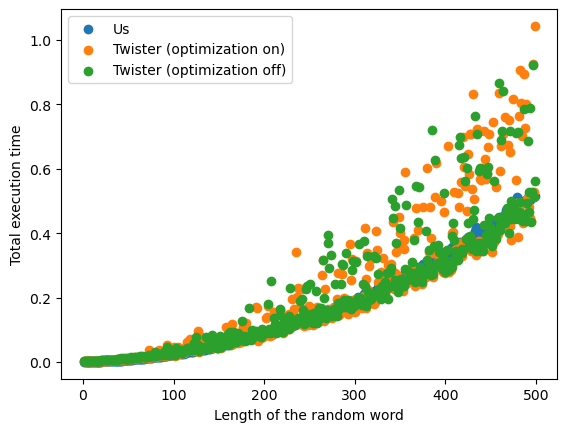

In [158]:
plt.scatter(range(1,n_max), time_us, label = 'Us')
plt.scatter(range(1,n_max), time_twister, label = 'Twister (optimization on)')
plt.scatter(range(1,n_max), time_twister_no_optimization, label = 'Twister (optimization off)')
plt.xlabel('Length of the random word')
plt.ylabel('Total execution time')
plt.legend()
plt.show()

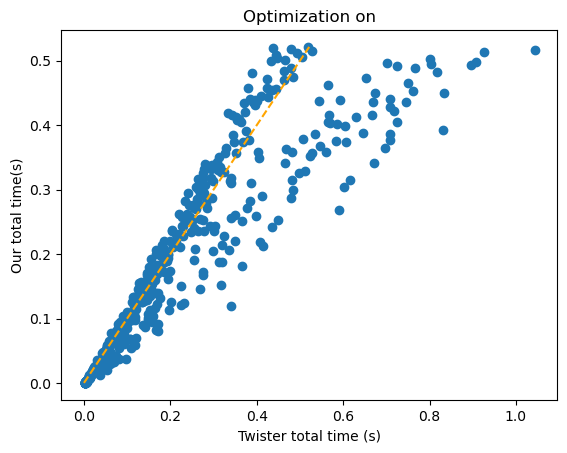

In [159]:
plt.scatter(time_twister, time_us)
plt.plot([min(time_us),max(time_us)],[min(time_us),max(time_us)], '--',c =  'orange')
plt.xlabel('Twister total time (s)')
plt.ylabel('Our total time(s)')
plt.title('Optimization on')
plt.show()

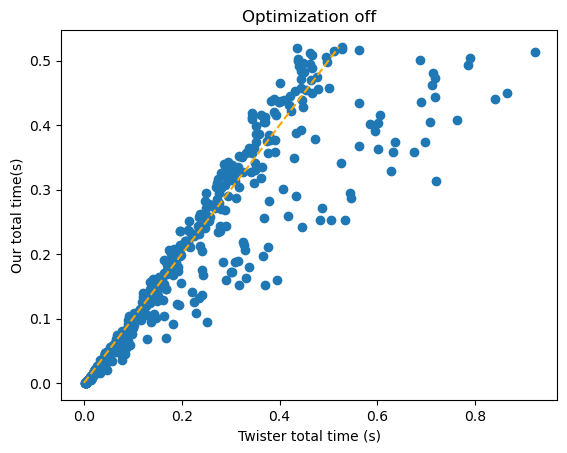

In [160]:
plt.scatter(time_twister_no_optimization, time_us)
plt.plot([min(time_us),max(time_us)],[min(time_us),max(time_us)], '--',c =  'orange')
plt.xlabel('Twister total time (s)')
plt.ylabel('Our total time(s)')
plt.title('Optimization off')
plt.show()

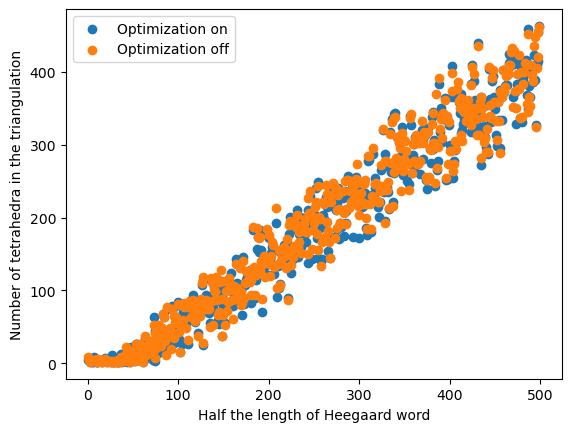

In [161]:
plt.scatter(range(1,n_max), tetra, label = 'Optimization on')
plt.scatter(range(1,n_max), tetra_no_optimization, label = 'Optimization off')

plt.xlabel('Half the length of Heegaard word')
plt.ylabel('Number of tetrahedra in the triangulation')
plt.legend()
plt.show()

# Genus 3

# Genus 5

In [146]:
# Create T2#T2
S = snappy.twister.Surface((5,0))
S.info(True)
print('Euler characteristic: ', S.Euler_characteristic)
print('Number of squares: ', S.num_squares)
print('Number of vertices: ', S.num_vertices)

A Twister surface of genus 5 with 0 boundary component(s)
Loops: a00, b01, b02, b03, b04, b05, b06, b07, b08, b09, c
Inverse names: A00, B01, B02, B03, B04, B05, B06, B07, B08, B09, C
Arcs: 
Inverse names: 
Macros: 
Intersection matrix:
['', 'a00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b09', 'c']
['a00', 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['b01', 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
['b02', 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['b03', 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]
['b04', 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
['b05', 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
['b06', 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
['b07', 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
['b08', 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
['b09', 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
['c', 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Euler characteristic:  -8
Number of squares:  10
Number of vertices:  2


In [149]:
S.random_word(10)

'Cb08CB05B05B01Ca00B08C'

In [145]:
n_max = 500
time_us = []
time_twister = []
time_twister_no_optimization = []

tetra = []
tetra_no_optimization = []

for n in range(1,n_max):
    word = S.random_word(n)
    
    '''# Us
    start = time.time()
    s = FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
    s.dehn_twist(word)
    s.homology()
    end = time.time()
    time_us.append(end-start)
    '''
    
    # Twister with optimization
    start = time.time()
    M = S.splitting(gluing = word, handles= 'a*A')
    M.homology()
    end = time.time()
    time_twister.append(end-start)
    tetra.append(M.num_tetrahedra())
    
    # Twister without optimization
    start = time.time()
    M = S.splitting(gluing = word, handles= 'a*A', optimize = False)
    M.homology()
    end = time.time()
    time_twister_no_optimization.append(end-start)
    tetra_no_optimization.append(M.num_tetrahedra())

AttributeError: 'Manifold' object has no attribute '_remove_finite_vertices'

In [ ]:
#plt.scatter(range(1,n_max), time_us, label = 'Us')
plt.scatter(range(1,n_max), time_twister, label = 'Twister (optimization on)')
plt.scatter(range(1,n_max), time_twister_no_optimization, label = 'Twister (optimization off)')
plt.xlabel('Length of the random word')
plt.ylabel('Total execution time')
plt.legend()
plt.show()

# Old stuff

In [ ]:
alpha_curves_standard = {'a': SLP.SLP(['b1*']), 'e': SLP.SLP(['d1*'])}
alpha_curves_edges = {'a':['a'], 'e':['e']}
generators_standard = {'A': SLP.SLP(['b1']), 'E': SLP.SLP(['d1']),'C1': SLP.SLP(['b2','d2','#0.#1','#2.#1','#3.#0']), 'C2': SLP.SLP(['d2','b2','#0.#1','#2.#1','#3.#0']),
                      'b1': SLP.SLP(['a*','c1*','#0.#1']), 'b2': SLP.SLP(['c1*','a*','#0.#1']),'d1': SLP.SLP(['e*','c2*','#0.#1']), 'd2': SLP.SLP(['c2*','e*','#0.#1'])}
generators_edge = {'a':['a'], 'b':['b1', 'b2'], 'c':['c1','c2'], 'd':['d1','d2'], 'e':['e']}